In [87]:
import argparse
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange, tqdm
from crm.core import Network
from crm.utils import get_explanations, get_metrics, make_dataset_cli, train, seed_all
import matplotlib.pyplot as plt

In [88]:
seed_all(24)

In [89]:
file_name = "./chess1.in"
with open(file_name, "r") as f:
    graph_file = f.readline()[:-1]
    train_file = f.readline()[:-1]
    test_files = f.readline()[:-1].split()
X_train, y_train, test_dataset, adj_list = make_dataset_cli(
    graph_file, train_file, test_files
)

In [90]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(nn.Linear(in_dim, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 256),nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 16), nn.ReLU(), nn.Linear(16, 2))
        
    def forward(self, x):
        return self.mlp(x)
    def reset(self):
        pass

In [91]:
mlp = MLP(23, 2)

In [92]:
idx = torch.randperm(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

X_train = X_train[:, :23].float()

In [93]:
X_train.float().dtype

torch.float32

In [100]:
def train(
    n: Network,
    X_train,
    y_train,
    num_epochs: int,
    optimizer: torch.optim.Optimizer,
    criterion,
    X_val=None,
    y_val=None,
    verbose: bool = False,
):
    mlp.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for e in trange(num_epochs):
        idx = torch.randperm(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]
        local_train_losses = []
        f_mapper = X_train
        out = n.forward(f_mapper)
        loss = criterion(out, y_train)
        local_train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        with torch.no_grad():
            train_losses.append(sum(local_train_losses) / len(local_train_losses))
            train_accs.append(
                get_metrics(n, X_train, y_train, output_dict=True)["accuracy"]
            )
            if X_val is not None and y_val is not None:
                local_val_losses = []
                for j in range(len(X_val)):
                    out = n.forward(X_val).reshape(1, -1)
                    loss = criterion(out, y_val[j].reshape(1))
                    local_val_losses.append(loss.item())
                    n.reset()
                val_losses.append(sum(local_val_losses) / len(local_val_losses))
                val_accs.append(
                    get_metrics(n, X_val, y_val, output_dict=True)["accuracy"]
                )
        if verbose:
            tqdm.write(f"Epoch {e}")
            tqdm.write(f"Train loss: {train_losses[-1]}")
            tqdm.write(f"Train acc: {train_accs[-1]}")
            if X_val is not None and y_val is not None:
                tqdm.write(f"Val loss: {val_losses[-1]}")
                tqdm.write(f"Val acc: {val_accs[-1]}")
            tqdm.write("##############################")
    return (
        (train_losses, train_accs, val_losses, val_accs)
        if X_val is not None and y_val is not None
        else (train_losses, train_accs)
    )

In [95]:
from sklearn.metrics import classification_report

In [106]:
def get_metrics(n, X_test, y_test, output_dict=False):
    y_pred = []
    for inp in X_test:
        y_pred.append(torch.argmax(n.forward(inp)))
        n.reset()
    cm = confusion_matrix(y_test.numpy(), torch.tensor(y_pred).numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return classification_report(
        (y_test).numpy(),
        torch.tensor(y_pred).numpy(),
        digits=4,
        output_dict=output_dict,
        zero_division=1,
    )

In [97]:
train_losses, train_accs = train(mlp, X_train, y_train, 80, torch.optim.Adam(mlp.parameters(), lr=1e-3), F.cross_entropy, verbose=True)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0
Train loss: 0.7117759585380554
Train acc: 0.324
##############################
Epoch 1
Train loss: 0.7044101357460022
Train acc: 0.3291
##############################
Epoch 2
Train loss: 0.6970650553703308
Train acc: 0.6571
##############################
Epoch 3
Train loss: 0.6899891495704651
Train acc: 0.676
##############################
Epoch 4
Train loss: 0.6821126937866211
Train acc: 0.676
##############################
Epoch 5
Train loss: 0.6729483604431152
Train acc: 0.676
##############################
Epoch 6
Train loss: 0.6629332304000854
Train acc: 0.676
##############################
Epoch 7
Train loss: 0.6522711515426636
Train acc: 0.676
##############################
Epoch 8
Train loss: 0.641025185585022
Train acc: 0.676
##############################
Epoch 9
Train loss: 0.6313424110412598
Train acc: 0.676
##############################
Epoch 10
Train loss: 0.6229174137115479
Train acc: 0.676
##############################
Epoch 11
Train loss: 0.6184666752815247
T

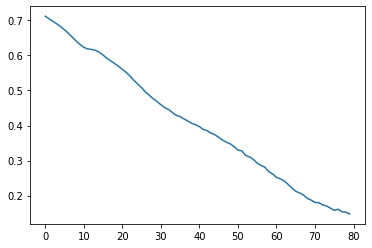

In [98]:
plt.plot(train_losses)

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

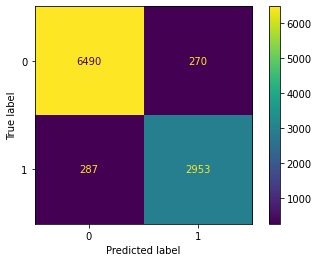

              precision    recall  f1-score   support

           0     0.9577    0.9601    0.9589      6760
           1     0.9162    0.9114    0.9138      3240

    accuracy                         0.9443     10000
   macro avg     0.9369    0.9357    0.9363     10000
weighted avg     0.9442    0.9443    0.9443     10000



In [112]:
mlp.eval()
print(get_metrics(mlp, X_train, y_train))

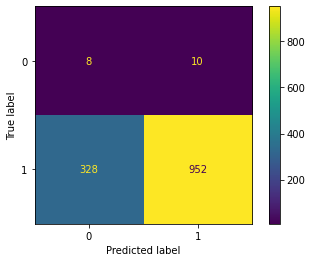

              precision    recall  f1-score   support

           0     0.0238    0.4444    0.0452        18
           1     0.9896    0.7438    0.8492      1280

    accuracy                         0.7396      1298
   macro avg     0.5067    0.5941    0.4472      1298
weighted avg     0.9762    0.7396    0.8381      1298



In [108]:
mlp.eval()
print(get_metrics(mlp, test_dataset[0][0][:, :23].float(), test_dataset[0][1]))

In [2]:
# TP:1280
# FP:18
# TN:0
# FN:0

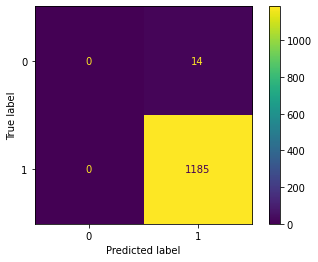

              precision    recall  f1-score   support

           0     1.0000    0.0000    0.0000        14
           1     0.9883    1.0000    0.9941      1185

    accuracy                         0.9883      1199
   macro avg     0.9942    0.5000    0.4971      1199
weighted avg     0.9885    0.9883    0.9825      1199



In [109]:
mlp.eval()
print(get_metrics(mlp, test_dataset[1][0][:, :23].float(), test_dataset[1][1]))

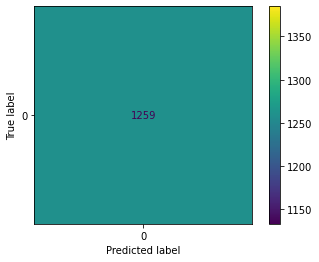

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000      1259

    accuracy                         1.0000      1259
   macro avg     1.0000    1.0000    1.0000      1259
weighted avg     1.0000    1.0000    1.0000      1259



In [110]:
mlp.eval()
print(get_metrics(mlp, test_dataset[2][0][:, :23].float(), test_dataset[2][1]))